# Installs and Imports

In [ ]:
!pip install pandas transformers datasets scikit-learn torch transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    XLMRobertaForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    TrainerCallback,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, precision_recall_fscore_support
import torch
import gc
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.cuda.amp import GradScaler, autocast


# Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Loading

In [ ]:
annotated_path = '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Dataset/INITIAL_ANNOTATED_SAMPLE.xlsx'
cleaned_dataset_path = '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Dataset/CLEANED_PREPROCESSED_DATA_03.xlsx'

df_annotated_nd = pd.read_excel(annotated_path, sheet_name='ND')
df_annotated_dn = pd.read_excel(annotated_path, sheet_name='DN')

df_cleaned_nd = pd.read_excel(cleaned_dataset_path, sheet_name='ND')
df_cleaned_dn = pd.read_excel(cleaned_dataset_path, sheet_name='DN')

In [ ]:
def filter_annotated_data(df, labels_to_remove):
    filtered_df = df[~df['numericalLabel'].isin(labels_to_remove)]
    filtered_df.dropna(subset=['numericalLabel'], inplace=True)
    filtered_df['numericalLabel'] = pd.to_numeric(filtered_df['numericalLabel'], errors='coerce')
    filtered_df.dropna(subset=['numericalLabel'], inplace=True)
    filtered_df['numericalLabel'] = filtered_df['numericalLabel'].astype(int)
    return filtered_df

labels_to_remove = ['NON-ENGLISH/TAGALOG/TAGLISH', 'NOT HELPFUL']

In [ ]:
df_annotated_nd_filtered = filter_annotated_data(df_annotated_nd, labels_to_remove)
df_annotated_dn_filtered = filter_annotated_data(df_annotated_dn, labels_to_remove)

texts_to_remove_nd = set(df_annotated_nd_filtered['text'])
texts_to_remove_dn = set(df_annotated_dn_filtered['text'])

df_cleaned_nd_filtered = df_cleaned_nd[~df_cleaned_nd['text'].isin(texts_to_remove_nd)]
df_cleaned_dn_filtered = df_cleaned_dn[~df_cleaned_dn['text'].isin(texts_to_remove_dn)]

<ipython-input-7-6005be8e2068>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(subset=['numericalLabel'], inplace=True)
<ipython-input-7-6005be8e2068>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numericalLabel'] = pd.to_numeric(filtered_df['numericalLabel'], errors='coerce')
<ipython-input-7-6005be8e2068>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [ ]:
with pd.ExcelWriter('/content/drive/My Drive/Research/SentimentAnalysisDivorce/Dataset/CLEANED_PREPROCESSED_DATA_04.xlsx') as writer:
    df_cleaned_nd_filtered.to_excel(writer, sheet_name='ND', index=False)
    df_cleaned_dn_filtered.to_excel(writer, sheet_name='DN', index=False)

# Exploratory Data Analysis

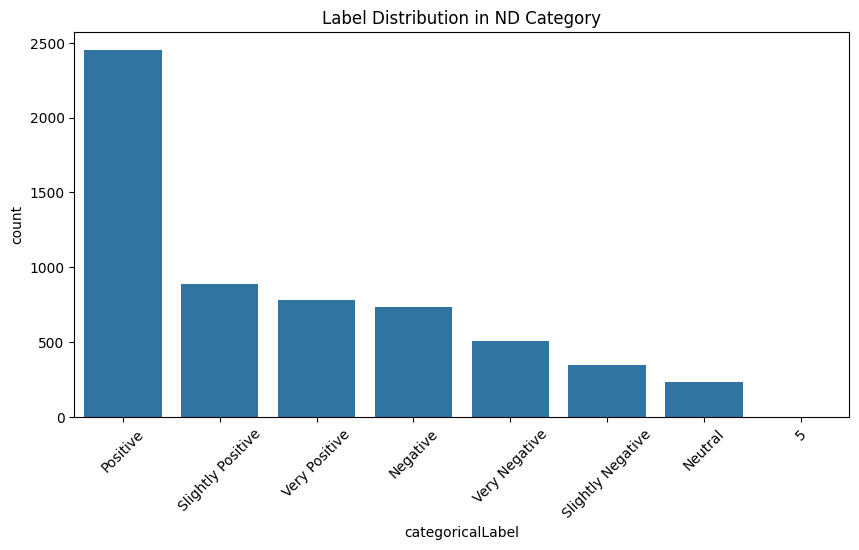

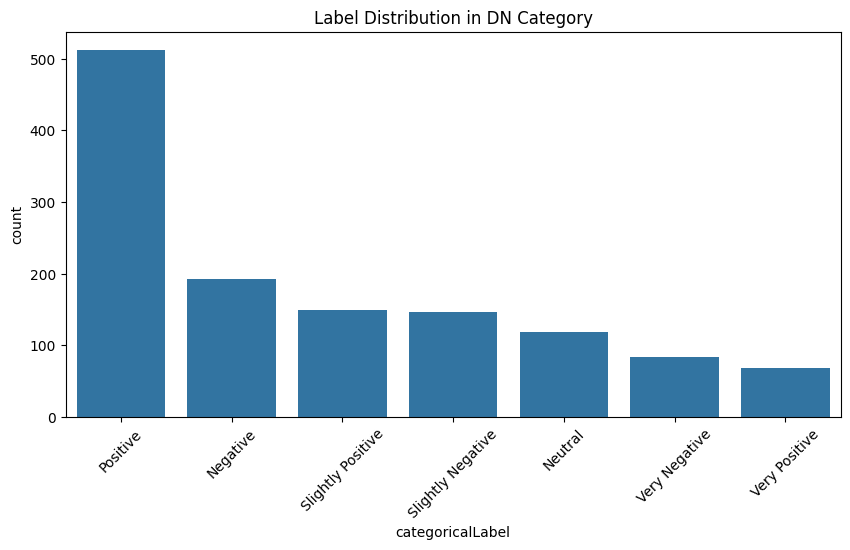

ND Category Statistics
categoricalLabel
Positive             2449
Slightly Positive     887
Very Positive         778
Negative              731
Very Negative         505
Slightly Negative     350
Neutral               233
5                       1
Name: count, dtype: int64

DN Category Statistics
categoricalLabel
Positive             512
Negative             193
Slightly Positive    149
Slightly Negative    146
Neutral              119
Very Negative         84
Very Positive         69
Name: count, dtype: int64


In [ ]:
def plot_label_distribution(df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(x='categoricalLabel', data=df, order=df['categoricalLabel'].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_label_distribution(df_annotated_nd_filtered, "Label Distribution in ND Category")
plot_label_distribution(df_annotated_dn_filtered, "Label Distribution in DN Category")

print("ND Category Statistics")
print(df_annotated_nd_filtered['categoricalLabel'].value_counts())
print("\nDN Category Statistics")
print(df_annotated_dn_filtered['categoricalLabel'].value_counts())

# Initial Training and Evaluation

In [ ]:
def preprocess_data(df, tokenizer, max_length=512):
    texts = df['text'].tolist()
    labels = df['numericalLabel'].tolist()
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
class BestModelSaverCallback(TrainerCallback):
    def __init__(self, trainer, tokenizer, patience=10, min_delta=0.0, output_dir=None):
        self.trainer = trainer
        self.tokenizer = tokenizer
        self.patience = patience
        self.min_delta = min_delta
        self.output_dir = output_dir
        self.best_loss = None
        self.best_accuracy = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        logs = kwargs.get("metrics", {})
        eval_loss = logs.get("eval_loss")
        eval_accuracy = logs.get("eval_accuracy")

        if eval_loss is not None and eval_accuracy is not None:
            if self.best_loss is None or eval_loss < self.best_loss - self.min_delta:
                self.best_loss = eval_loss
                self.best_accuracy = eval_accuracy
                self.patience_counter = 0

                if self.output_dir:
                    self.trainer.model.save_pretrained(self.output_dir)
                    self.tokenizer.save_pretrained(self.output_dir)
            else:
                self.patience_counter += 1
                if self.patience_counter > self.patience:
                    control.should_training_stop = True


In [ ]:
xlm_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

inputs_nd_xlm = preprocess_data(df_annotated_nd_filtered, xlm_tokenizer)
inputs_dn_xlm = preprocess_data(df_annotated_dn_filtered, xlm_tokenizer)

In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def split_dataset(inputs):
    train_size = int(0.8 * len(inputs['input_ids']))
    eval_size = len(inputs['input_ids']) - train_size
    train_dataset = {}
    eval_dataset = {}
    for key in inputs.keys():
        train_dataset[key] = inputs[key][:train_size]
        eval_dataset[key] = inputs[key][train_size:]
    return CustomDataset(train_dataset), CustomDataset(eval_dataset)

In [ ]:
train_dataset_nd, eval_dataset_nd = split_dataset(inputs_nd_xlm)
train_dataset_dn, eval_dataset_dn = split_dataset(inputs_dn_xlm)

In [ ]:
def train_and_save_model(train_dataset, eval_dataset, labels, category_name):
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')

    model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(np.unique(labels)))
    tokenizer = xlm_tokenizer

    training_args = TrainingArguments(
        output_dir=f'/content/drive/My Drive/Research/SentimentAnalysisDivorce/Models/{category_name}',
        evaluation_strategy='epoch',
        save_strategy='no',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=30,
        weight_decay=0.01,
        load_best_model_at_end=False,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    best_model_saver_callback = BestModelSaverCallback(trainer, tokenizer, patience=10, min_delta=0.0, output_dir=training_args.output_dir)
    trainer.add_callback(best_model_saver_callback)

    trainer.train()

    best_model_path = training_args.output_dir
    trainer.save_model(best_model_path)
    print(f"Best model saved at {best_model_path}")

In [ ]:
labels_nd = inputs_nd_xlm['labels'].numpy()
labels_dn = inputs_dn_xlm['labels'].numpy()

In [ ]:
train_and_save_model(train_dataset_nd, eval_dataset_nd, labels_nd, 'ND')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.494757,0.412805,0.391291,0.508341,0.412805
2,1.630800,1.123605,0.539174,0.545290,0.614078,0.539174
3,1.630800,1.102438,0.581297,0.572325,0.632387,0.581297
4,1.080700,1.109765,0.620893,0.633826,0.673887,0.620893
5,1.080700,1.217893,0.655434,0.643213,0.642003,0.655434
6,0.821500,1.248995,0.625948,0.637158,0.673811,0.625948
7,0.602600,1.230778,0.636057,0.638655,0.653682,0.636057
8,0.602600,1.386710,0.641955,0.644939,0.662512,0.641955
9,0.447800,1.551299,0.650379,0.659012,0.677634,0.650379
10,0.447800,1.586336,0.656276,0.664481,0.682420,0.656276


Best model saved at /content/drive/My Drive/Research/SentimentAnalysisDivorce/Models/ND


In [ ]:
train_and_save_model(train_dataset_dn, eval_dataset_dn, labels_dn, 'DN')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.872382,0.145098,0.075729,0.407511,0.145098
2,No log,1.791029,0.207843,0.194963,0.274914,0.207843
3,No log,1.684460,0.290196,0.289481,0.343912,0.290196
4,No log,1.615293,0.286275,0.273923,0.397573,0.286275
5,No log,1.596880,0.325490,0.316227,0.396098,0.325490
6,No log,1.658220,0.313725,0.313767,0.437845,0.313725
7,No log,1.632442,0.337255,0.343514,0.427763,0.337255
8,1.509000,1.707502,0.396078,0.397256,0.460961,0.396078
9,1.509000,1.612723,0.454902,0.461259,0.477058,0.454902
10,1.509000,1.848684,0.396078,0.410087,0.443515,0.396078


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best model saved at /content/drive/My Drive/Research/SentimentAnalysisDivorce/Models/DN


# Pseudolabel Generation

In [ ]:
cleaned_dataset_path = '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Dataset/CLEANED_PREPROCESSED_DATA_04.xlsx'

df_cleaned = pd.read_excel(cleaned_dataset_path)

In [ ]:
def preprocess_data(df, tokenizer, max_length=512):
    texts = df['text'].tolist()
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    return inputs

In [ ]:
tokenizer_xlm = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
model_paths = {
    'ND': '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Models/ND',
    'DN': '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Models/DN'
}

models = {category: XLMRobertaForSequenceClassification.from_pretrained(path) for category, path in model_paths.items()}

In [ ]:
def generate_pseudolabels(df, model, tokenizer):
    inputs = preprocess_data(df, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, axis=1).numpy()
    return predictions

In [ ]:
df_cleaned_nd_filtered = df_cleaned[df_cleaned['category'] == 'ND']
df_cleaned_dn_filtered = df_cleaned[df_cleaned['category'] == 'DN']

In [ ]:
df_cleaned_nd_filtered['pseudolabel_ND'] = generate_pseudolabels(df_cleaned_nd_filtered, models['ND'], tokenizer_xlm)
df_cleaned_dn_filtered['pseudolabel_DN'] = generate_pseudolabels(df_cleaned_dn_filtered, models['DN'], tokenizer_xlm)

In [ ]:
output_path = '/content/drive/My Drive/Research/SentimentAnalysisDivorce/Dataset/PSEUDOLABELED_DATA_01.xlsx'
df_cleaned.to_excel(output_path, index=False)

In [ ]:
print(f"Pseudolabeled data saved to {output_path}")